### importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
stemmer = WordNetLemmatizer()
import pickle
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Mohamed
[nltk_data]     Mousa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### load data

In [2]:
train = pd.read_csv('twitter_training.csv',sep=',', names=['Tweet_ID','Entity','Sentiment','Tweet_content'])
test = pd.read_csv('twitter_validation.csv',sep=',', names=['Tweet_ID','Entity','Sentiment','Tweet_content'])

### EDA

In [3]:
train

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [4]:
train['Entity'].value_counts()

TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)               

In [5]:
train['Sentiment'].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64

In [6]:
train.isna().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64


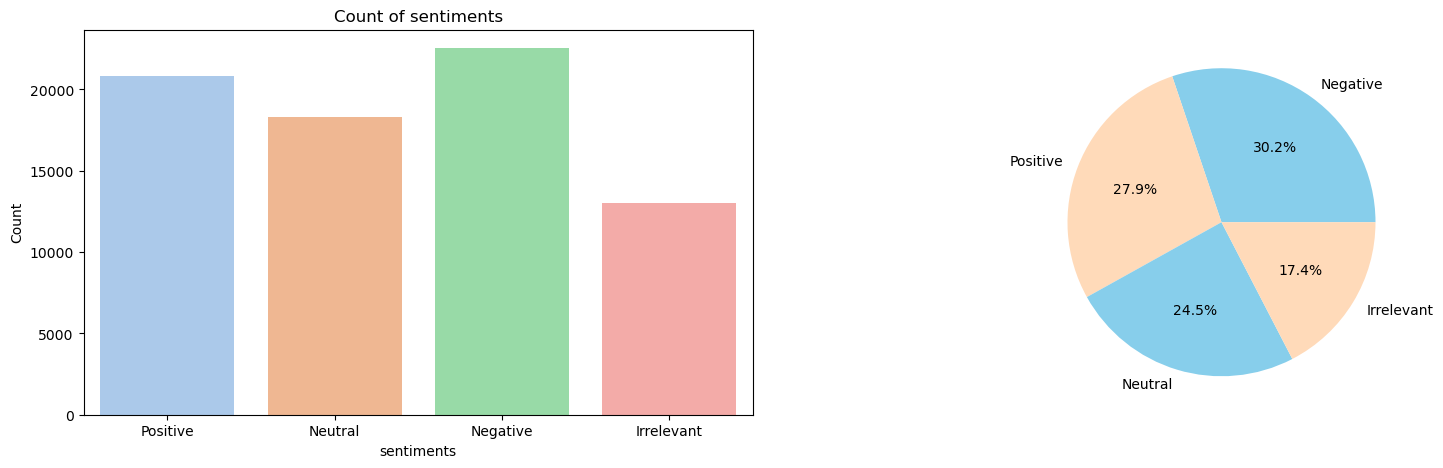

In [7]:
#### count of sentiment and percentage
print(train["Sentiment"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(train.Sentiment,ax=ax[0],palette="pastel");
g1.set_title("Count of sentiments")
g1.set_ylabel("Count")
g1.set_xlabel("sentiments")
g2 = plt.pie(train["Sentiment"].value_counts().values,labels=train.Sentiment.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

In [8]:
train.isnull().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

In [9]:
train.duplicated().sum()

2700

In [10]:
### drop duplicates
train.drop_duplicates(inplace=True)
train.dropna(inplace=True, axis=0)

In [11]:
train.reset_index(inplace=True)

In [12]:
train.shape

(71656, 5)

In [13]:
train["Tweet_content"][90]

'I hate that this easy horrible modifier event on game 10 last forever. That is the best fun i’ve taken in the past until they added them horrible modifiers. @Borderlands please send me the option to play mayhem 10 but turn the modifiers for PLS'

In [14]:
### CLEANING TexT


stemmer = WordNetLemmatizer()

def clean_txt(x):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(x))
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    # Converting to Lowercase
    document = document.lower()
   
    document = word_tokenize(document)
    
    document = [word for word in document if word not in stopwords.words('english')]

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    return document

In [15]:
train['Tweet_content'] = train['Tweet_content'].apply(lambda x:clean_txt(x))

In [17]:
### CHARACTER COUNT 
train['Desc Char Length'] = train['Tweet_content'].apply(
    lambda x :  len(x))
### WORD LENGTH
train['Desc Word Length'] = train['Tweet_content'].apply(
    lambda x :  len(x.split()))

In [18]:
train = train[train["Desc Word Length"] != 0]
train = train[train["Tweet_content"] != ""] 
train = train[train["Desc Char Length"] != 1]
train = train[train["Desc Char Length"] != 2]
train.reset_index(inplace=True)

In [19]:
clean_train = train

In [20]:
test['Tweet_content'] = test['Tweet_content'].apply(lambda x:clean_txt(x))

In [ ]:
#train.describe()

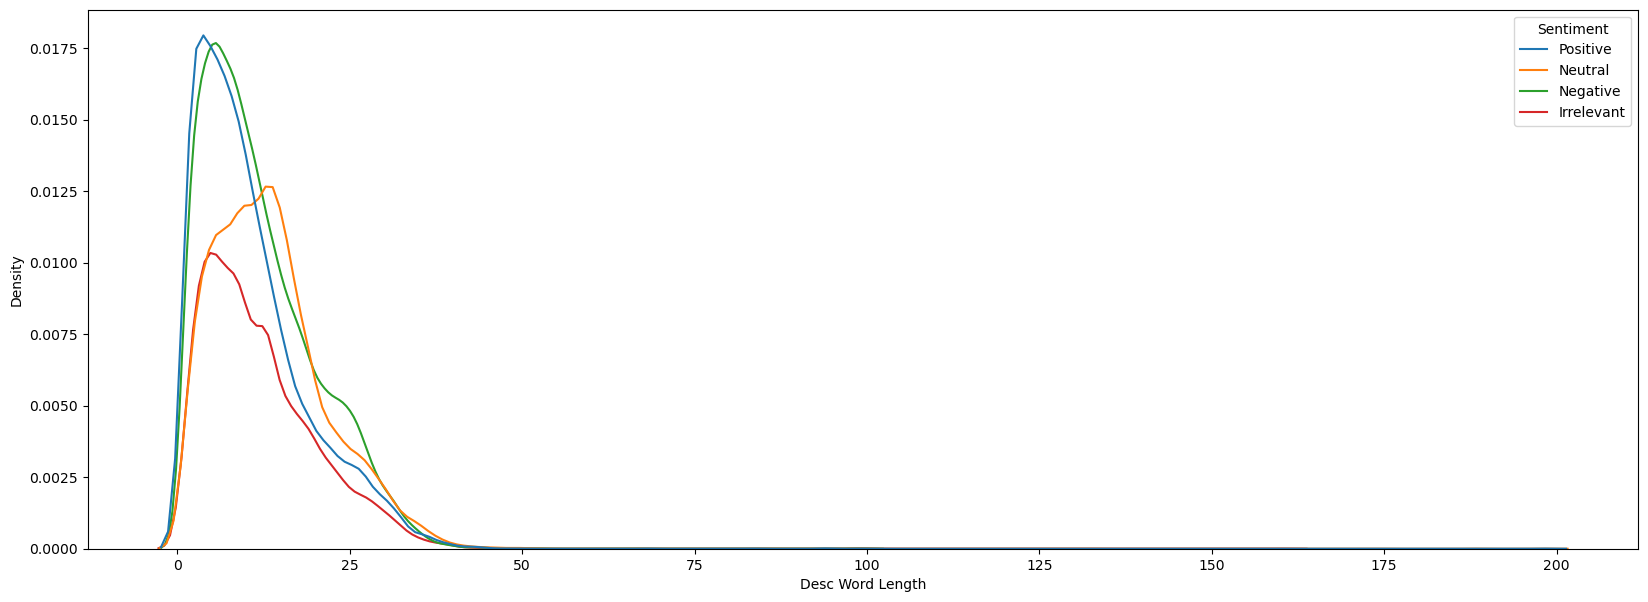

In [21]:
### diplay range of word's count
plt.figure(figsize=(20, 7))
sns.kdeplot(data=train, x='Desc Word Length', hue='Sentiment')
plt.show()

In [26]:
size_dict = {'Positive':1, 
        'Neutral':2, 
        'Negative':3, 
        'Irrelevant':4}
train['ENC_Sentiment'] = train['Sentiment'].map(size_dict)
test['ENC_Sentiment'] = test['Sentiment'].map(size_dict)

In [32]:
X_train = train['Tweet_content']
y_train = train['ENC_Sentiment']
X_test = test['Tweet_content']
y_test = test['ENC_Sentiment']

### saveing the data

In [33]:
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [34]:
from keras.preprocessing.text import Tokenizer

In [ ]:
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

### splitting data and tokenizeation

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
max_phrase_len= max(len(seq) for seq in X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_phrase_len)
max_words = len(tokenizer.word_index)+1

### build a model

In [37]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [39]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test,y_test),
    epochs = 8,
    batch_size = 512
)

Epoch 1/8
137/137 [==============================] - 2350s 17s/step - loss: 0.2795 - accuracy: 0.9010 - val_loss: 0.2203 - val_accuracy: 0.9360
Epoch 2/8
137/137 [==============================] - 1835s 13s/step - loss: 0.2242 - accuracy: 0.9193 - val_loss: 0.2100 - val_accuracy: 0.9380
Epoch 3/8
137/137 [==============================] - 17054s 125s/step - loss: 0.1861 - accuracy: 0.9324 - val_loss: 0.2052 - val_accuracy: 0.9450
Epoch 4/8
137/137 [==============================] - 8979s 66s/step - loss: 0.1622 - accuracy: 0.9407 - val_loss: 0.1987 - val_accuracy: 0.9520
Epoch 5/8
137/137 [==============================] - 1370s 10s/step - loss: 0.1462 - accuracy: 0.9456 - val_loss: 0.2214 - val_accuracy: 0.9420
Epoch 6/8
137/137 [==============================] - 1516s 11s/step - loss: 0.1306 - accuracy: 0.9513 - val_loss: 0.2388 - val_accuracy: 0.9410
Epoch 7/8
137/137 [==============================] - 51790s 381s/step - loss: 0.1213 - accuracy: 0.9542 - val_loss: 0.2497 - val_accur

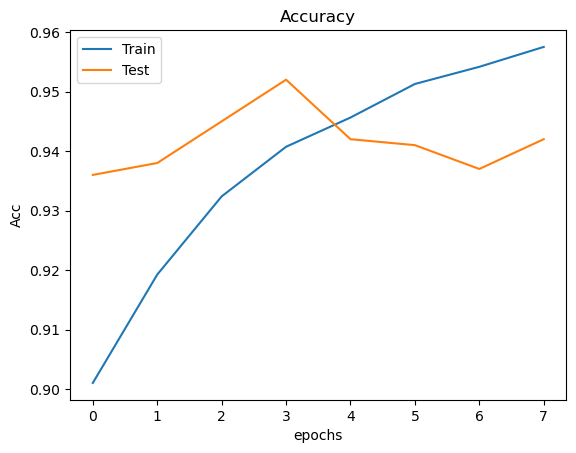

In [40]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

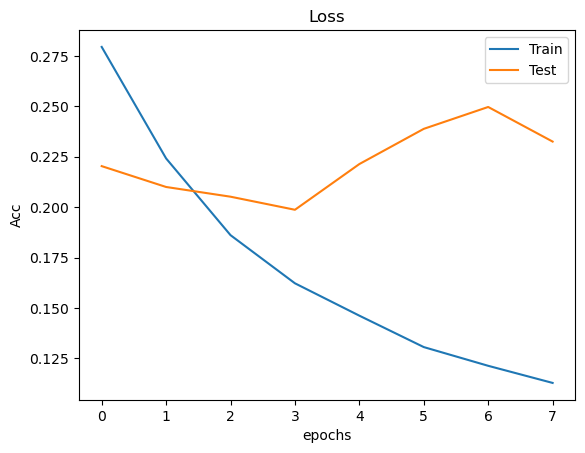

In [41]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
# max_words = 8192
# tokenizer = Tokenizer(
#     num_words = max_words,
#     filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
# )
# tokenizer.fit_on_texts(X_train)
# X_train = tokenizer.texts_to_sequences(X_train)
# X_train = pad_sequences(X_train, maxlen = max_phrase_len)
# y_train = to_categorical(y_train)

In [ ]:
# tfidfconverter = TfidfVectorizer()
# X = tfidfconverter.fit_transform(documents).toarray()

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)